-----------------------------------------------------------------------------------------------------------------------
# Crude Oil Production Forecasting
-----------------------------------------------------------------------------------------------------------------------

----------------
## **Background** 
----------------

The world economy relies heavily on hydrocarbons, particularly oil, for the provision of energy required in transportation and other industries. Crude oil production is considered one of the most important indicators of the global economy. 

For countries that product oil, oil production forecast is significant in decision-making and investment scenario evaluation.

------------------
## **Objective**
------------------

In this case study, I will analyze and use historical oil production data, from 1992 to 2018, for a country to forecast its future production. I will build a time series forecasting model using the AR, MA, ARMA, and ARIMA models  to forecast oil production. 

--------------------------
## **Data**
--------------------------

The dataset that I will be using is 'Crude Oil Production by Country'. This dataset contains the yearly oil production of 222 countries, but for simplicity, I will forecast only one country's future oil production.

In [1]:
# Version check 
import statsmodels

statsmodels.__version__

'0.12.0'

In [2]:
# Libraries to do data manipulation
import numpy as np

import pandas as pd

# Library to do data visualization
import matplotlib.pyplot as plt

# Library to do time series decomposition
import statsmodels.api as sm

# Module to create ACF and PACF plots
from statsmodels.graphics import tsaplots

# Module to build AR, MA, ARMA, and ARIMA models
from statsmodels.tsa.arima.model import ARIMA

# Module to implement MSE and RSME during model evaluation
from sklearn.metrics import mean_squared_error

# Code for ignoring unnecessary warnings while executing some code  
import warnings
warnings.filterwarnings("ignore")

## **Load the dataset**

This dataset has crude oil production data as time series for 222 countries starting from 1992 till 2018. This is a time series data with yearly frequency. Since the frequency of this dataset is yearly, we will not get any seasonal patterns in this time series. However, we can expect cyclicity in the data which spans over multiple years.

In [5]:
data = pd.read_csv('/Users/yuchenzhou/Desktop/MIT/Practical_DS/Crude_Oil_Production_by_Country.csv')

data.head()

,Country,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,United States,7171,6847,6662,6560,6465,6451,6252,5881,5822,...,5349,5478,5654,6502.0,7467.0,8759.0,9431.0,8831.0,9352.0,10962.0
1,Saudi Arabia,8332,8198,8120,8231,8218,8362,8389,7833,8404,...,8250,8900,9458,9832.0,9693.0,9735.0,10168.0,10461.0,10134.0,10425.0
2,Russia,7632,6730,6135,5995,5850,5920,5854,6079,6479,...,9495,9694,9774,9922.0,10054.0,10107.0,10253.0,10551.0,10580.0,10759.0
3,Canada,1605,1679,1746,1805,1837,1922,1981,1907,1977,...,2579,2741,2901,3138.0,3325.0,3613.0,3677.0,3679.0,3977.0,4264.0
4,Iraq,425,512,553,560,579,1155,2150,2508,2571,...,2391,2399,2626,2983.0,3054.0,3368.0,4045.0,4444.0,4454.0,4613.0


Since there are observations from 222 countries, i.e., we have 222 different time series. We will select only one time series for forecasting purpose in this project.

In this project, I take United States as an example. 


In [7]:
# Use loc and index = 2 to fetch the data for United States from the original dataset
united_states = data.loc[0]

# Drop the variable country
united_states = pd.DataFrame(united_states).drop(['Country'])

# Fetch the two columns - YEAR and OIL PRODUCTION
united_states = united_states.reset_index()

united_states.columns = ['YEAR', 'OIL PRODUCTION']

# Convert OIL PRODUCTION to integer
united_states['OIL PRODUCTION'] = united_states['OIL PRODUCTION'].astype(int)

# Conver the YEAR  to datetime
united_states['YEAR'] = pd.to_datetime(united_states['YEAR'])

# Setting the variable YEAR as the index 
united_states = united_states.set_index('YEAR')


united_states.head()

,OIL PRODUCTION
YEAR,
1992-01-01,7171
1993-01-01,6847
1994-01-01,6662
1995-01-01,6560
1996-01-01,6465


## **Visualizing the time series and decomposing it**

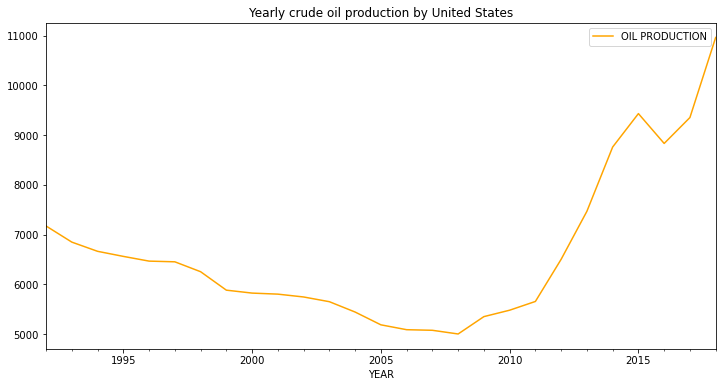

In [14]:
ax = united_states.plot(color = 'orange', figsize = (12, 6))

ax.set_title('Yearly crude oil production by United States')

plt.show()

The above plot shows that the oil production of United States was declining from the early 1990s to the mid 2000s but has been increasing constantly since then.


Next I will see the `trend`, `seasonality`, and `white noise` of time series data. Since this is yearly frequency data, there would not be any `seasonal` patterns after decomposing the time series.

The function, `seasonal_decompose`, decomposes the time series into `trend`, `seasonal`, and `white noise` components using moving averages. 

In [16]:
#  decompose the time series into its individual components
decomposition = sm.tsa.seasonal_decompose(united_states)

In [17]:
decomposed_data = pd.DataFrame()

# Extracting the trend component 
decomposed_data['trend'] = decomposition.trend

# Extracting the seasonal component 
decomposed_data['seasonal'] = decomposition.seasonal

# Extracting the white noise
decomposed_data['random_noise'] = decomposition.resid

Plotting the above three components in a single plot

<AxesSubplot:xlabel='YEAR'>

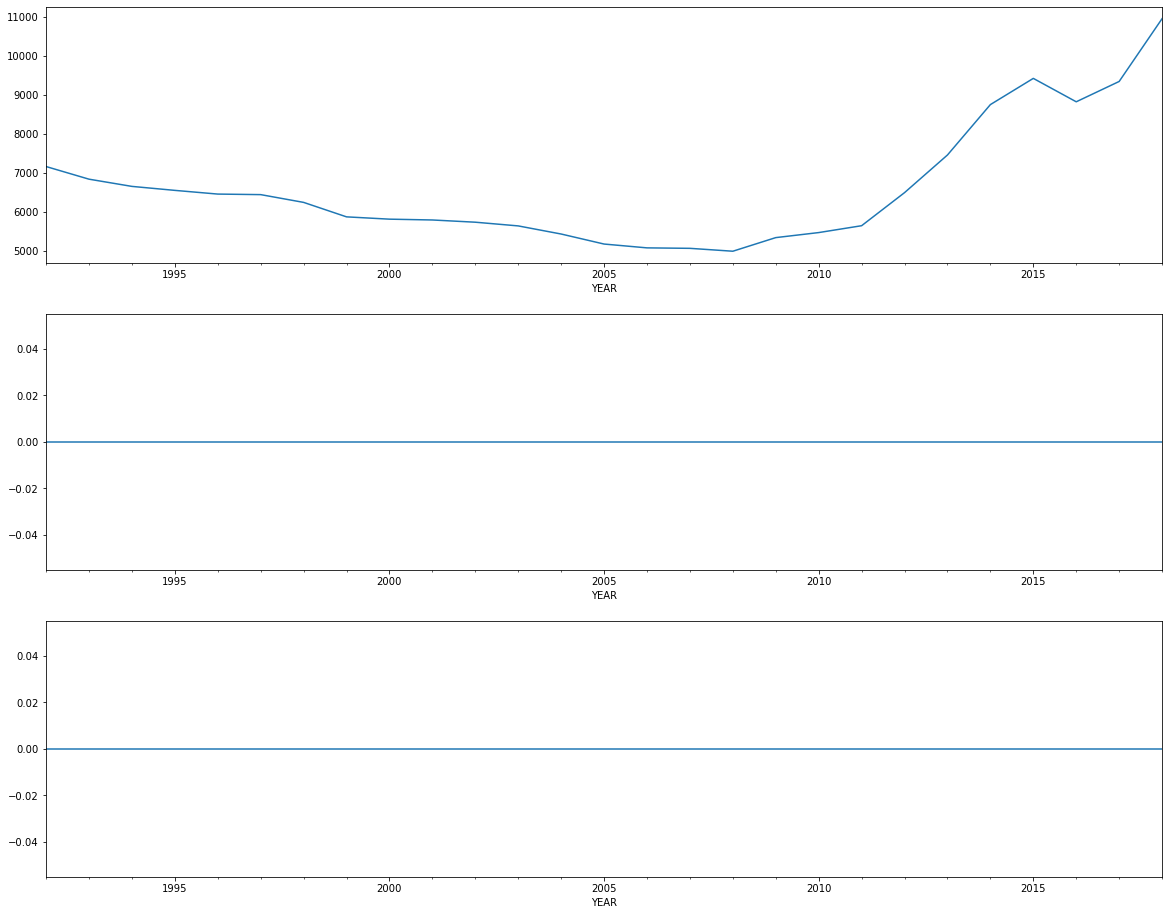

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (20, 16))

decomposed_data['trend'].plot(ax = ax1)

decomposed_data['seasonal'].plot(ax = ax2)

decomposed_data['random_noise'].plot(ax = ax3)

From the above plot, we see the `seasonal` and `residual` components are zero, as this time series has a yearly frequency.

## **Splitting the dataset**

In [19]:
# Using the first 20 years data as the training data
train_data = united_states.loc['1992-01-01' : '2012-01-01']

# Using the last 7 years data as the test data
test_data = united_states.loc['2012-01-01':]

**visualize the train and the test data in the same plot**

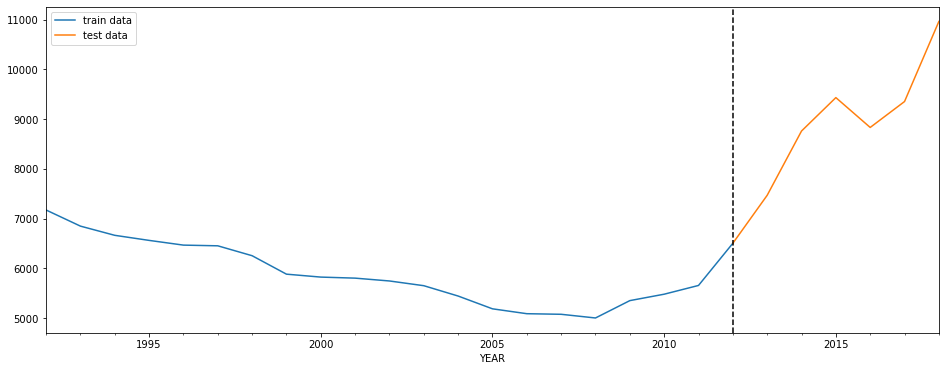

In [20]:
fig, ax = plt.subplots(figsize = (16, 6))

train_data.plot(ax = ax)

test_data.plot(ax = ax)

plt.legend(['train data', 'test data'])

# Showing the time which divides the original data into train and test
plt.axvline(x = '2012-01-01', color = 'black', linestyle = '--')

plt.show()

## **Checking for stationarity**

identify non-stationarity in the time series by performing  **Augmented Dicky-Fuller Test**.

- **Null Hypothesis:** The time series is non stationary
- **Alternate Hypothesis:** The time series is stationary

In [21]:
from statsmodels.tsa.stattools import adfuller

# Implementing ADF test on the original time series data
result = adfuller(train_data['OIL PRODUCTION'])

print(result[0])

print(result[1]) # To get the p-value

print(result[4])

-0.5829098523091641
0.8747971281795595
{'1%': -4.01203360058309, '5%': -3.1041838775510207, '10%': -2.6909873469387753}


The p-value is around 0.87, which is higher than 0.05. Hence, we fail to reject the null hypothesis, and we can say the time series is non-stationary. We can also see this visually by comparing the above ADF statistic and visually inspecting the time series.

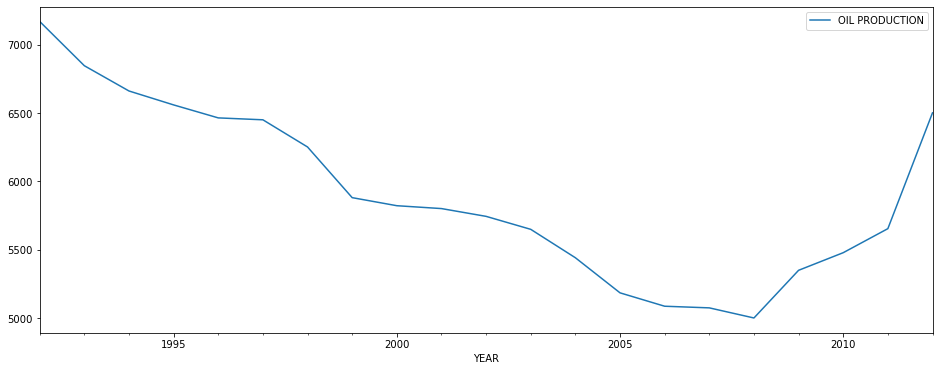

ADF Statistic: -0.5829098523091641
p-value: 0.8747971281795595


In [22]:
result = adfuller(train_data['OIL PRODUCTION'])

fig, ax = plt.subplots(figsize = (16, 6))

train_data.plot(ax = ax)

plt.show()

# Printing the results

print('ADF Statistic:', result[0])

print('p-value:', result[1])

take the 1st order difference of the data and check if it becomes stationary

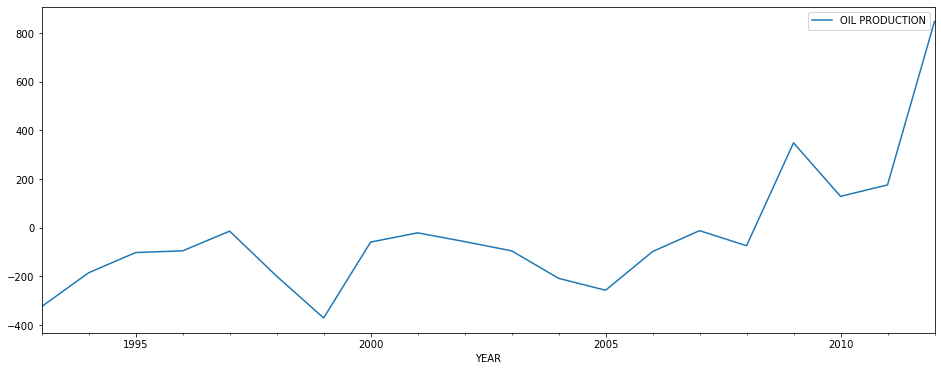

ADF Statistic: 1.575800707060134
p-value: 0.9977831288888281


In [23]:
# Taking the 1st order differencing of the timeseries
train_data_stationary = train_data.diff().dropna()

# Implementing ADF test on the first order differenced time series data
result = adfuller(train_data_stationary['OIL PRODUCTION'])

fig, ax = plt.subplots(figsize = (16, 6))

train_data_stationary.plot(ax = ax)

plt.show()

print('ADF Statistic:', result[0])

print('p-value:', result[1])

the p-value is around 0.99, which is again higher than 0.05. Hence, we fail to reject the null hypothesis, and we can say the time series is non-stationary. 

Then take the 2nd order differencing now and perform the same test.

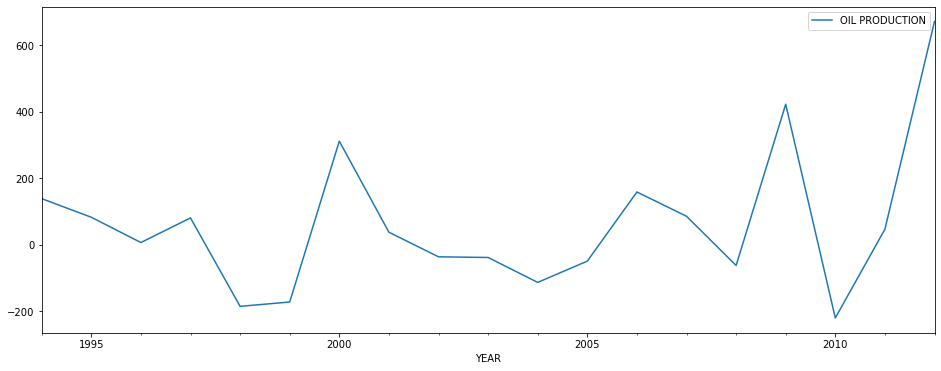

ADF Statistic: -1.5580506601256086
p-value: 0.504624368911218


In [24]:
# Taking the 2nd order differencing of the time series
train_data_stationary = train_data.diff().diff().dropna()

# Implementing ADF test on the second order differenced time series data
result = adfuller(train_data_stationary['OIL PRODUCTION'])

fig, ax = plt.subplots(figsize = (16, 6))

train_data_stationary.plot(ax = ax)

plt.show()

print('ADF Statistic:', result[0])

print('p-value:', result[1])

Here, the p-value is around 0.50, which is again higher than 0.05. Hence, we fail to reject the null hypothesis, and we can say the time series is non-stationary. 

Then take the 3rd order differencing now and perform the same test.

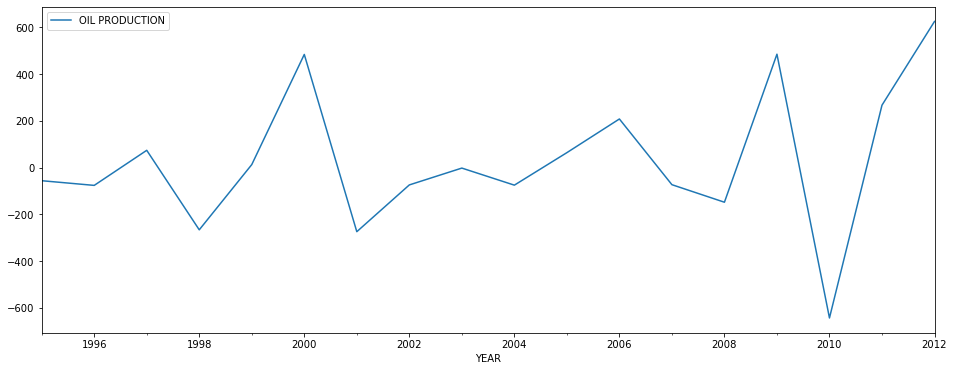

ADF Statistic: -6.191607528895948
p-value: 6.10365022487616e-08


In [25]:
# Taking the 3rd order differencing of the time series
train_data_stationary = train_data.diff().diff().diff().dropna()

# Implementing ADF test on the second order differenced time series data
result = adfuller(train_data_stationary['OIL PRODUCTION'])

fig, ax = plt.subplots(figsize = (16, 6))

train_data_stationary.plot(ax = ax)

plt.show()

print('ADF Statistic:', result[0])

print('p-value:', result[1])

Now, the p-value is less than 0.05, and we can say that after taking 3rd order differencing.

## **ACF and PACF Plots**

ACF and PACF plots are used to identify the model's order in ARIMA models. These plots help to find the parameters `p` and `q`. 

**generate the ACF and PACF plots.**

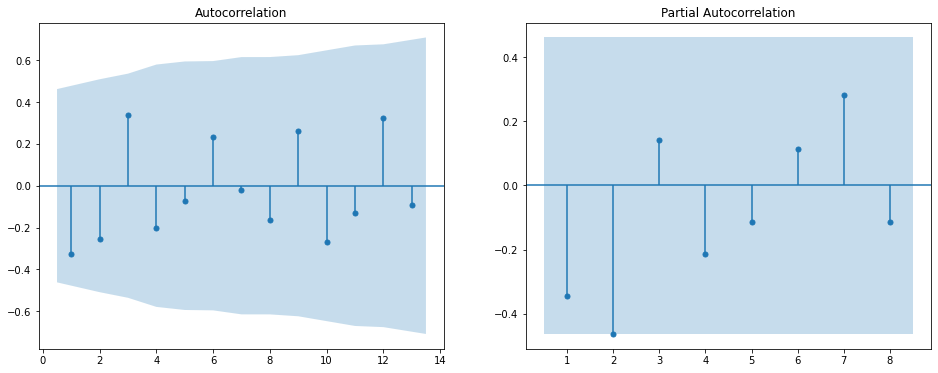

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

# ACF charts, from lag = 1
tsaplots.plot_acf(train_data_stationary, zero = False, ax = ax1)

# ACF charts, from lag = 1 till lag = 8
tsaplots.plot_pacf(train_data_stationary, zero = False, ax = ax2, lags = 8)

plt.show()

From the above plots, it does not look like this stationary time series follows a pure AR or MA model. It implies that the time series follows an ARMA or ARIMA model. 

To find out the optimal values of p, d, and q, we need to do a hyper-parameter search to find their optimal values.

The PACF seems to cut off at lag 2, but we cannot be sure because it is too close to the boundary.

I will try several different modeling techniques on this time series:
- AR (p)
- MA (q)
- ARMA (p, q)
- ARIMA (p, d, q)

and then we will check which one performs better.

## **Evaluation Metrics**

## **AR Modeling**

$$
y_{t}=a_{1} y_{t-1} + a_{2} y_{t-2} + \ldots + a_{p} y_{t-p} + \epsilon_{t}
$$

build four AR models at lags 1, 2, 3, and 4.

In [28]:
# AR model, p = 1
ar_1_model = ARIMA(train_data_stationary, order = (1, 0, 0))

#  p = 2
ar_2_model = ARIMA(train_data_stationary, order = (2, 0, 0))

# p = 3
ar_3_model = ARIMA(train_data_stationary, order = (3, 0, 0))

# p = 4
ar_4_model = ARIMA(train_data_stationary, order = (4, 0, 0))

In [29]:
# Fit all the models
ar_1_results = ar_1_model.fit()

ar_2_results = ar_2_model.fit()

ar_3_results = ar_3_model.fit()

ar_4_results = ar_4_model.fit()

As we have passed the stationary time series while fitting the above AR models. The forecasts that we get will also be on the same scale, i.e., after doing double differencing of original time series. Therefore, to get the forecasts in the original scale, we need to **inverse transform** the time series data. The below function is helping us to do that inverse transformation.

In [30]:
def plot_predicted_output(results, ax):
    predictions = np.cumsum(np.cumsum(results.predict(start = 19, end = 25))) + train_data.iloc[-1][0]

    predictions.index = test_data.index
    
    train_data.plot(ax = ax, label = 'train', 
                    title = 'AIC: {}'.format(np.round(results.aic, 2)) + 
                           ' , ' +
                           'RMSE: {}'.format(np.round(np.sqrt(mean_squared_error(test_data, predictions)), 2)))
    
    test_data.plot(ax = ax) 

    predictions.plot(ax = ax)
    
    ax.legend(['train data', 'test data', 'forecasted values'])

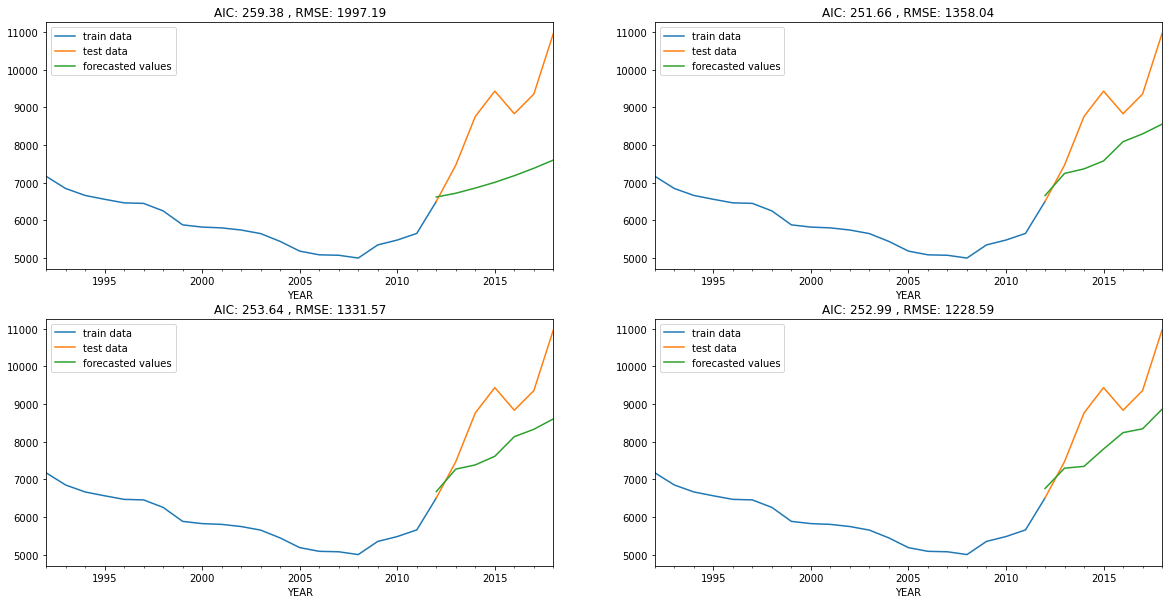

In [31]:
# Plotting the forecasted values 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

plot_predicted_output(ar_1_results, ax1)

plot_predicted_output(ar_2_results, ax2)

plot_predicted_output(ar_3_results, ax3)

plot_predicted_output(ar_4_results, ax4)

plt.show()

if we check the RMSE values, it is the least for AR(4) or ARIMA(4, 0, 0) model, 

In [32]:
ar_4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   18
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -120.495
Date:                Mon, 20 Jun 2022   AIC                            252.990
Time:                        00:39:40   BIC                            258.332
Sample:                    01-01-1995   HQIC                           253.727
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0306     17.221      0.466      0.641     -25.722      41.783
ar.L1         -0.8563      0.371     -2.308      0.021      -1.583      -0.129
ar.L2         -1.0208      0.534     -1.911      0.056      -2.067       0.026
ar.L3         -0.3271      0.410     -0.799      0.425      -1.130       0.476
ar.L4         -0.4350      0.340     -1.280      0.201      -1.101       0.231
sigma2      3.249e+04   2.03e+04      1.600      0.110   -7311.529    7.23e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.45   Prob(JB):                         0.83
Heteroskedasticity (H):               2.22   Skew:                             0.10
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

the equation for this model would be:

$$
y_{t}= 8.0306 - 0.8563 y_{t-1} - 1.0208 y_{t-2} - 0.3271 y_{t-3} - 0.4350 y_{t-4} + \epsilon_{t}
$$

## **MA Modeling**

a generalized equation for the MA model: 

$$
y_{t}=m_{1} \epsilon_{t-1} + m_{2} \epsilon_{t-2} + \ldots+m_{q} \epsilon_{t-q} + \epsilon_{t}
$$

In [33]:
# MA model,q = 1
ma_1_model = ARIMA(train_data_stationary, order = (0, 0, 1))

# q = 2
ma_2_model = ARIMA(train_data_stationary, order = (0, 0, 2))

# q = 3
ma_3_model = ARIMA(train_data_stationary, order = (0, 0, 3))

# q = 4
ma_4_model = ARIMA(train_data_stationary, order = (0, 0, 4))

In [34]:
ma_1_results = ma_1_model.fit()

ma_2_results = ma_2_model.fit()

ma_3_results = ma_3_model.fit()

ma_4_results = ma_4_model.fit()

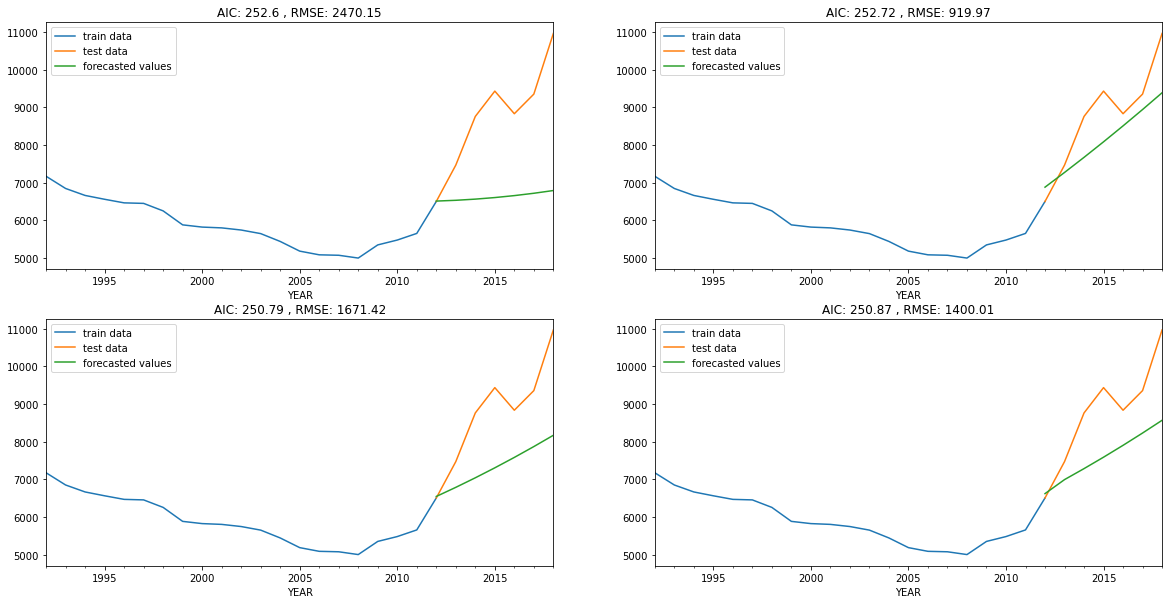

In [35]:
# Plotting 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

plot_predicted_output(ma_1_results, ax1)

plot_predicted_output(ma_2_results, ax2)

plot_predicted_output(ma_3_results, ax3)

plot_predicted_output(ma_4_results, ax4)

plt.show()

RMSE is significantly lower for MA(2) model in comparison to all the other models. So, the best model that we have got using MA modeling, is MA(2). 

In [36]:
ma_2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   18
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -122.361
Date:                Mon, 20 Jun 2022   AIC                            252.721
Time:                        00:42:11   BIC                            256.283
Sample:                    01-01-1995   HQIC                           253.212
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9008     12.355      0.882      0.378     -13.315      35.116
ma.L1         -1.6985      3.257     -0.521      0.602      -8.082       4.685
ma.L2          0.9765      3.677      0.266      0.791      -6.229       8.182
sigma2      3.456e+04   1.12e+05      0.307      0.759   -1.86e+05    2.55e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.54   Prob(JB):                         0.66
Heteroskedasticity (H):               1.59   Skew:                             0.51
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **ARMA Modeling**

Below is a generalized equation for the ARMA model.

$$
y_{t}=a_{1} y_{t-1}+m_{1} \epsilon_{t-1} + \ldots + \epsilon_{t}
$$

In [37]:
# ARMA model,p = 2 and q = 1
ar_2_ma_1_model = ARIMA(train_data_stationary, order = (2, 0, 1))

# p = 2 and q = 2
ar_2_ma_2_model = ARIMA(train_data_stationary, order=(2, 0, 2))

# p = 3 and q = 2
ar_3_ma_2_model = ARIMA(train_data_stationary, order = (3, 0, 2))

# p = 2 and q = 3
ar_2_ma_3_model = ARIMA(train_data_stationary, order = (2, 0, 3))

In [38]:
# Fitting 

ar_2_ma_1_results = ar_2_ma_1_model.fit()

ar_2_ma_2_results = ar_2_ma_2_model.fit()

ar_3_ma_2_results = ar_3_ma_2_model.fit()

ar_2_ma_3_results = ar_2_ma_3_model.fit()

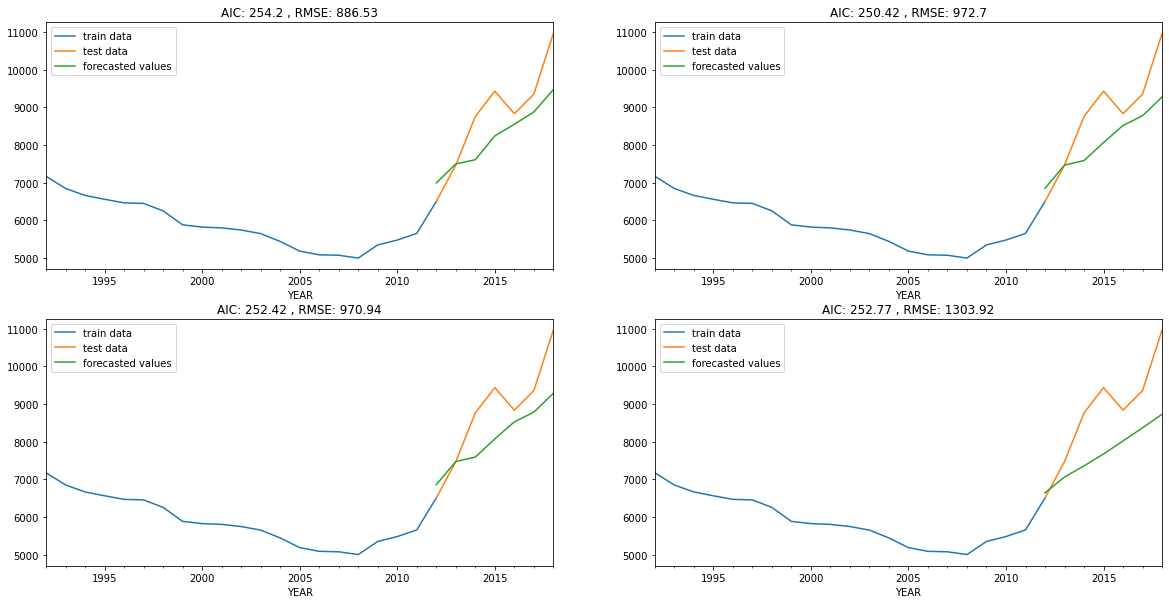

In [39]:
# Plotting 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

plot_predicted_output(ar_2_ma_1_results, ax1)

plot_predicted_output(ar_2_ma_2_results, ax2)

plot_predicted_output(ar_3_ma_2_results, ax3)

plot_predicted_output(ar_2_ma_3_results, ax4)

plt.show()

In ARIMA(2, 0, 1), the `RMSE` is significantly lower than the other models. 

In [40]:
ar_2_ma_1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   18
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -122.098
Date:                Mon, 20 Jun 2022   AIC                            254.195
Time:                        00:45:29   BIC                            258.647
Sample:                    01-01-1995   HQIC                           254.809
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3372     35.267      0.236      0.813     -60.785      77.460
ar.L1         -1.2901      0.178     -7.246      0.000      -1.639      -0.941
ar.L2         -0.8183      0.250     -3.271      0.001      -1.309      -0.328
ma.L1          0.9913      4.376      0.227      0.821      -7.585       9.568
sigma2      3.582e+04   1.49e+05      0.241      0.810   -2.56e+05    3.28e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.47   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.23   Prob(JB):                         0.83
Heteroskedasticity (H):               1.75   Skew:                             0.12
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **ARIMA Modeling**

In [41]:
train_data = train_data.astype('float32')

In ARIMA function here, we do not need to pass stationary time series, we can simply pass the original time without differencing.

use d = 3 since we know that after triple differencing the original time series becomes a stationary time series.

In [42]:
# p = 2, d = 3 and q = 1
ar_2_d_3_ma_1_model = ARIMA(train_data, order = (2, 3, 1))

# p = 1, d = 3 and q = 2
ar_1_d_3_ma_2_model = ARIMA(train_data, order = (1, 3, 2))

# p = 2, d = 3 and q = 2
ar_2_d_3_ma_2_model = ARIMA(train_data, order = (2, 3, 2))

# p = 3, d = 3 and q = 2
ar_3_d_3_ma_2_model = ARIMA(train_data, order = (3, 3, 2))

In [43]:
# Fitting 

ar_2_d_3_ma_1_results = ar_2_d_3_ma_1_model.fit()

ar_1_d_3_ma_2_results = ar_1_d_3_ma_2_model.fit()

ar_2_d_3_ma_2_results = ar_2_d_3_ma_2_model.fit()

ar_3_d_3_ma_2_results = ar_3_d_3_ma_2_model.fit()

In [44]:
def plot_predicted_output_new(results, ax):
    
    predictions = results.predict(start = 19, end = 25)
    
    # Setting indices of the test data into prediction values
    predictions.index = test_data.index
    
    # Computing the AIC and RMSE metrics for the model and printing it into title of the plot
    train_data.plot(ax = ax, label = 'train', 
                    
                    title = 'AIC: {}'.format(np.round(results.aic, 2)) + 
                           ' , ' +
                           'RMSE: {}'.format(np.round(np.sqrt(mean_squared_error(test_data, predictions)), 2)))
    
    test_data.plot(ax = ax) 
    

    predictions.plot(ax = ax)
    
    ax.legend(['train data', 'test data', 'forecasted values'])

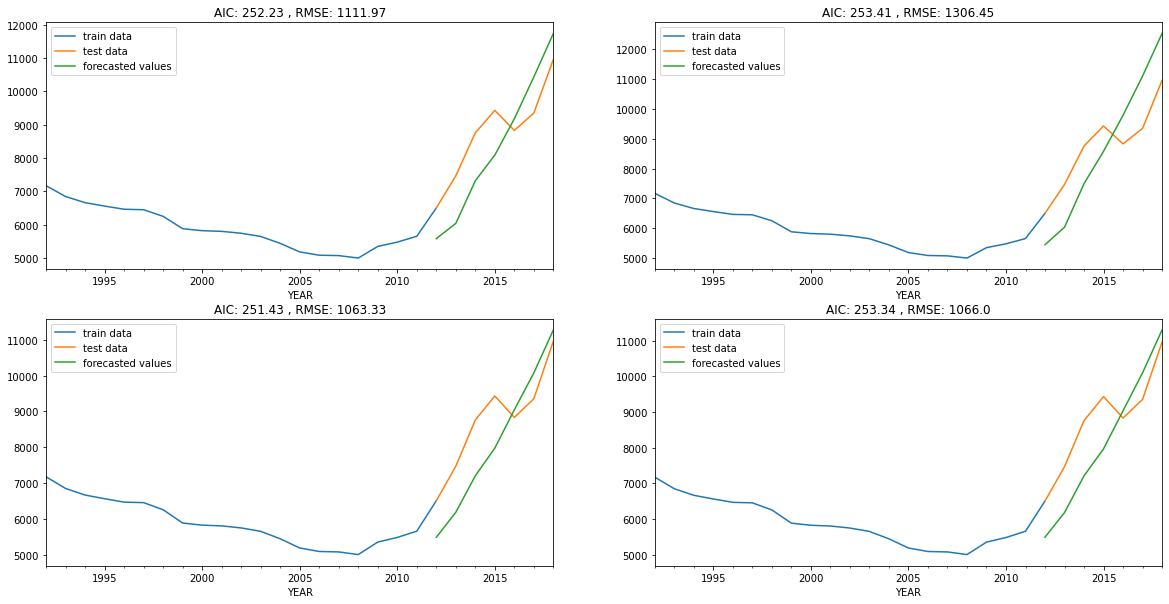

In [45]:
# Plotting 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

plot_predicted_output_new(ar_2_d_3_ma_1_results, ax1)

plot_predicted_output_new(ar_1_d_3_ma_2_results, ax2)

plot_predicted_output_new(ar_2_d_3_ma_2_results, ax3)

plot_predicted_output_new(ar_3_d_3_ma_2_results, ax4)

plt.show()

ARIMA(2, 3, 2) is the best model in comparison to others, as it has comparable AIC to other models and less RMSE.

In [46]:
ar_2_d_3_ma_2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   21
Model:                 ARIMA(2, 3, 2)   Log Likelihood                -120.713
Date:                Mon, 20 Jun 2022   AIC                            251.427
Time:                        00:50:16   BIC                            255.879
Sample:                    01-01-1992   HQIC                           252.041
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9701      0.276     -3.518      0.000      -1.511      -0.430
ar.L2         -0.5351      0.318     -1.685      0.092      -1.158       0.087
ma.L1          0.2168      7.403      0.029      0.977     -14.293      14.726
ma.L2         -0.7778      6.047     -0.129      0.898     -12.630      11.074
sigma2      2.577e+04   1.97e+05      0.131      0.896   -3.61e+05    4.12e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.41   Prob(JB):                         0.64
Heteroskedasticity (H):               1.85   Skew:                            -0.10
Prob(H) (two-sided):                  0.47   Kurtosis:                         1.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**train the model with the same parameters on the full data for United States and get the forecasts for the next 7 years, i.e., from 2019-01-01 to 2025-01-01.**

In [47]:
final_model = ARIMA(united_states, order = (2, 3, 2))

final_model_results = final_model.fit()

In [48]:
forecasted_ARIMA = final_model_results.predict(start = '2019-01-01', end = '2025-01-01')

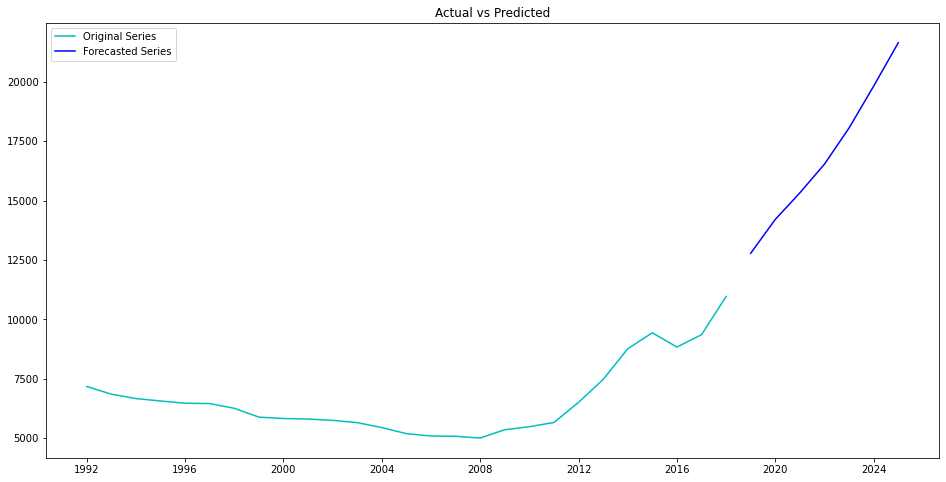

In [49]:
# Plotting 

plt.figure(figsize = (16, 8))

plt.plot(united_states, color = 'c', label = 'Original Series')

plt.plot(forecasted_ARIMA, label = 'Forecasted Series', color = 'b')

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

- The forecast indicates that, according to the historic data, the oil production is going to constantly increase for United Sates.

## **Conclusion**

 - We have built different types of models using search for the optimal parameters for each. We have compared all the models based on the evaluation metrics `AIC` and `RMSE`.
 - The AIC for all the models is approximately the same. So, the choice of model is more dependent on RMSE for the current data.
 - Overall, the model `ARIMA(2, 3, 2) has given the best results` and we have used the same to forecast the oil production for United States.